In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# File paths
image_dir = r"diabetic_retinopathy\colored_images"
csv_path = r"diabetic_retinopathy\train.csv"


In [3]:
df = pd.read_csv(csv_path)
df.head()


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [4]:
df = pd.read_csv(csv_path)
label_map = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR'
}


In [5]:
class RetinopathyDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.df = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_id = self.df.iloc[idx]['id_code']
        label = self.df.iloc[idx]['diagnosis']
        class_name = label_map[label]
        img_path = f"{self.image_dir}/{class_name}/{img_id}.png"

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
# Transform 
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Train-validation split
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['diagnosis'], random_state=42)

train_dataset = RetinopathyDataset(train_df, image_dir, transform=transform)
val_dataset = RetinopathyDataset(val_df, image_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


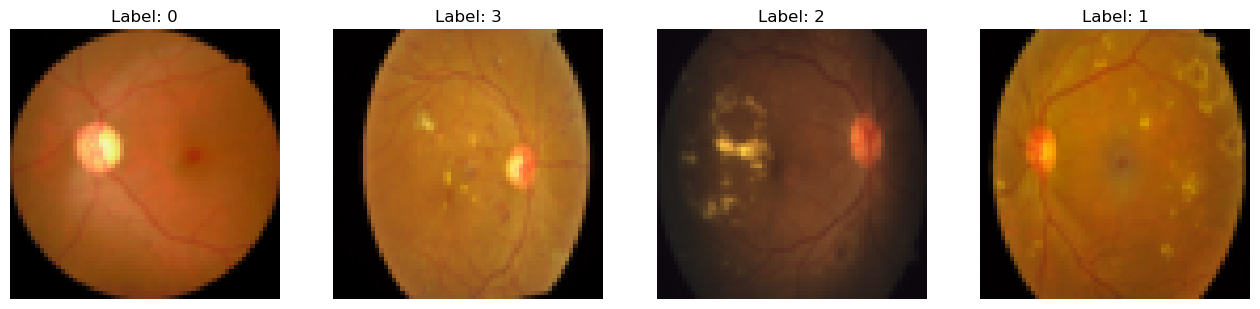

In [7]:
def show_images_from_loader(loader):
    import matplotlib.pyplot as plt
    images, labels = next(iter(loader))
    images = images[:4]
    labels = labels[:4]
    images = images * 0.5 + 0.5  # Undo normalization
    images = images.permute(0, 2, 3, 1).numpy()
    
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    for i in range(4):
        ax[i].imshow(images[i])
        ax[i].set_title(f"Label: {labels[i].item()}")
        ax[i].axis('off')
    plt.show()

# View images
show_images_from_loader(train_loader)


In [8]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 8, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(8, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        # After 3 MaxPool2d with stride 2 on 64x64 input -> 8x8 output
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 8 * 8, 64),
            nn.ReLU(),
            nn.Linear(64, 5)  # 5 classes
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [14]:
# Early stopping config
num_epochs = 20
patience = 3
best_val_loss = float('inf')
epochs_no_improve = 0


for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss
    train_acc = correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {running_loss:.4f}, Accuracy: {train_acc:.4f}")

    # Validation
    model.eval()
    val_loss, val_correct = 0.0, 0
    val_total = 0
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss += criterion(val_outputs, val_labels).item()
            val_correct += (val_outputs.argmax(1) == val_labels).sum().item()
            val_total += labels.size(0)
    val_acc = val_correct / len(val_loader.dataset)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

# Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model.pt")  # Save the best model
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            break

Epoch [1/20] - Loss: 125.6905, Accuracy: 0.7422
Validation Loss: 37.5367, Validation Accuracy: 0.7108
Epoch [2/20] - Loss: 124.1968, Accuracy: 0.7426
Validation Loss: 37.9269, Validation Accuracy: 0.7121
Epoch [3/20] - Loss: 121.7119, Accuracy: 0.7511
Validation Loss: 38.0288, Validation Accuracy: 0.7271
Epoch [4/20] - Loss: 121.7662, Accuracy: 0.7583
Validation Loss: 37.2325, Validation Accuracy: 0.7162
Epoch [5/20] - Loss: 121.2790, Accuracy: 0.7474
Validation Loss: 37.4360, Validation Accuracy: 0.7299
Epoch [6/20] - Loss: 116.2637, Accuracy: 0.7617
Validation Loss: 38.0723, Validation Accuracy: 0.7108
Epoch [7/20] - Loss: 117.1030, Accuracy: 0.7634
Validation Loss: 37.4208, Validation Accuracy: 0.7176
